In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Union
from scipy.stats import norm
import os
import glob
import openpyxl as xls
from datetime import datetime

In [2]:
link = os.getcwd()
folder = glob.glob('*')
data_link = link + "\\data.csv"
print(data_link)
#rate_link = link + "\\rate.csv"
#risk_link = link + "\\cac40.csv"

C:\Users\milan\OneDrive\Bureau\Projet\data.csv


In [3]:
data = pd.read_csv(data_link, index_col = "Dates", sep = ";", parse_dates = True)
risk = pd.DataFrame(data["SXXR Index"])
rate = pd.DataFrame(data["EONIA Index"])

**Ploting both EONIA and EUROSTOXX600 historical data**

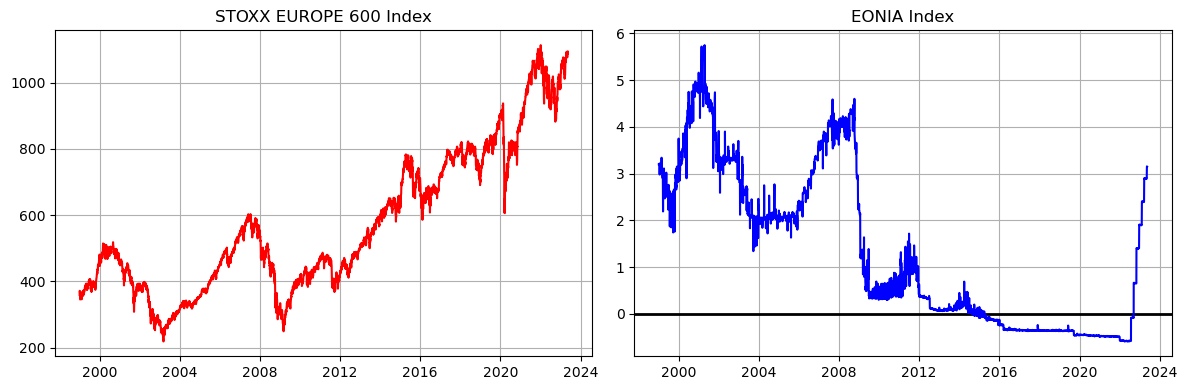

In [4]:
# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.plot(risk, c = "r")
ax1.set_title('STOXX EUROPE 600 Index')
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(rate, c = "blue")
ax2.set_title('EONIA Index')
ax2.grid(True)

# Affichage de la figure
plt.tight_layout()
plt.show()

In [5]:
def investment_period(df:pd.DataFrame = risk, y0:Union[int,str]=2000, horizon:int=5, alldata:bool=False):
    """
    parameters:
        - df : The dataframe
        - y0 : The year, if str, or the date in which the investor start to invest
        - horizon : the period of investment.
        - alldata : a boolean variable.
    
    This function is used to get the dataset during an "investment period", denoted by IP.
        - If alldata is True, the IP start from y0 to the end of the dataset
        - If alldata is False, the IP start from y0 to the y0 to y0+horizon-1
        - If y0's type is int, we include the last day of the previous year into the dataset.
    """
    if (alldata == False):
        if type(y0)==int:
            # Only take the last day of past year
            table_investment_JN = pd.DataFrame(df[str(y0-1):str(y0-1)].iloc[-1]).T 
            # The period of investment
            table_investment_J = pd.DataFrame(df[str(y0):str(y0+horizon-1)])
            # concatenate
            table_investment = pd.concat([table_investment_JN, table_investment_J])
        elif type(y0)==str:
            yyyy = int(y0[:4]) # Give the 4 first letters from yyyy-mm-dd
            mm_dd = y0[4:] # Give the remaining -mm-dd
            yyyh_mm_dd = str(yyyy+horizon-1) + mm_dd
            table_investment = pd.DataFrame(df[y0:yyyh_mm_dd])
    else:
        if type(y0)==int:
            # Only take the last day of past year
            table_investment_JN = pd.DataFrame(df[str(y0-1):str(y0-1)].iloc[-1]).T
            table_investment_J = pd.DataFrame(df[str(y0):])
            table_investment = pd.concat([table_investment_JN, table_investment_J])
        elif type(y0)==str:
            table_investment = pd.DataFrame(df[y0:])        
    return table_investment

In [6]:
def returns(df:pd.DataFrame=risk, initial_investment:float=100.0, y0:Union[int,str]=2000,
           horizon:int=5, alldata:bool=False):
    """
    Parameters:
        - df : The DataFrame
        - initial_investment : The initial value that the client deposits 
        - y0 : The moment (year or day) when the client start to invest
        - horizon : The horizon of investment, by defaul 5 years
        - alldata : 
            - if True : Return the whole dataset from y0 to the end
            - if False : Return the y0 + horizon -1 results
    
    This function allows to compute at first, the returns of the risk asset, from y0 to y0+horizon-1 (if alldata = False)
    or from y0 to the end (if alldata = True). Those return will be apply to the initial amount the client choose to invest
    at beginning
    """
    data = investment_period(df, y0, horizon, alldata)
    S0 = float(data.iloc[0])
    stock_returns = [(float(data.iloc[x])/S0 -1) for x in range(len(data)) ]
    stock_returns = np.array(stock_returns).reshape(-1,1)
    data["Risk return"] = initial_investment * (1 + stock_returns)
    data = data.drop(data.columns[0],axis = 1)
    return data

In [7]:
def monetarize(df:pd.DataFrame=rate, initial_investment:float=100.0, y0:Union[int,str]=2000,
           horizon:int=5, alldata:bool=False):
    """
    parameters:
        - df : The dataset
        - initial_investment : The initial value that the client deposits 
        - y0 : The moment (year or day) when the client start to invest
        - horizon : The horizon of investment, by defaul 5 years
        - alldata : 
            - if True : Return the whole dataset from y0 to the end
            - if False : Return the y0 + horizon -1 results
            
    This function allows to compute the investment to the safe asset (bond), by starting with the amount the investor
    paid.
    """
    data = investment_period(df, y0, horizon, alldata)
    bond_rate = [x for x in data.iloc[:,0]]
    bond_rate = np.array(bond_rate).reshape(-1,1)
    bond = []
    compteur = 0
    for i in bond_rate:
        if compteur == 0:
            bond.append(initial_investment)
        else:
            investment = float(bond[compteur-1] * (1 + i/(365*100)))
            bond.append(investment)
        compteur += 1
    data["RiskFree return"] = bond
    data = data.drop(data.columns[0], axis = 1)
    return data

In [8]:
def createxls(df:pd.DataFrame, opt:bool=False):
    # XLS futures names 
    now = datetime.now()
    yyyy = str(now.year)
    mm = str(now.month).zfill(2)
    dd = str(now.day).zfill(2)
    hour = str(now.hour).zfill(2)
    minute = str(now.minute).zfill(2)
    second = str(now.second).zfill(2)
    name = f"DataFrame_{yyyy}_{mm}_{dd}_{hour}_{minute}_{second}"
    # Create excel
    work = xls.Workbook()
    feuille = work.active #take the first sheet by default
    # Path
    path = os.getcwd()
    full_name = path + "\\01. Excel Data\\" + name +".xlsx"
    #Save :
    work.save(full_name)
    work.close()
    # Updated 
    df.to_excel(full_name, index = opt)
    print(f"The following excel is successfuly registered : {name}")

<AxesSubplot:>

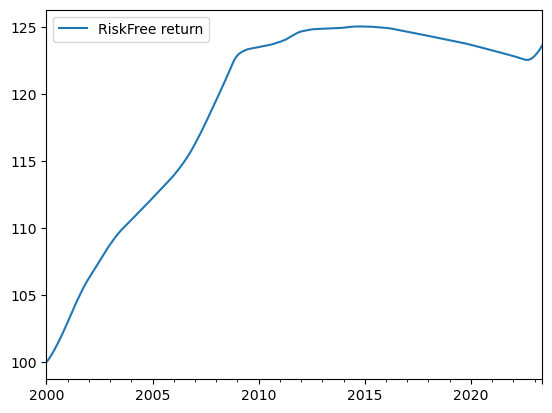

In [9]:
monetarize(alldata = True).plot()

<AxesSubplot:>

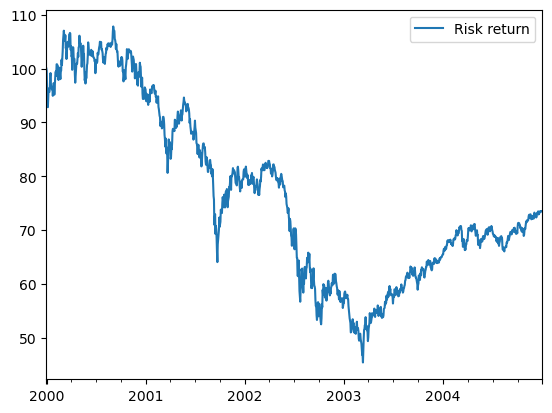

In [10]:
returns(initial_investment = 100).plot()

In [11]:
class Information:
    def __init__(self, dfrisk:pd.DataFrame=risk, dfrate:pd.DataFrame=rate, 
                 initial_investment:float=100.0, garant:float=1.0, y0:str="2000",
                 horizon:int=5, multiplier:float=2, activation:list=[3,6,9,12]):
        
        # Instance our 8 parameters
        self.dfrisk = dfrisk
        self.dfrate = dfrate
        self.initial_investment = initial_investment
        self.garant = garant
        self.y0 = y0
        self.horizon = horizon
        self.multiplier = multiplier
        self.activation = activation
        
        # Create others instances
        self.nb_days = len(self.dfrisk)
        self.nb_period_year = self.nb_days / self.horizon
        
        # Date and Horizon's format : yyyy(-mm-dd) and (yyyy+h)(-mm-dd)
        self.yyyy = int(self.y0[:4])
        self.yyyh = str(self.yyyy + self.horizon-1)
        if len(self.y0)==4:
            self.inception = str(self.yyyy)
            self.end = self.yyyh
            self.onlyear = True
        elif len(self.y0)==7:
            self.mm = str(self.y0[5:7])
            self.inception = str(self.yyyy) + "-" + self.mm
            self.end = str(self.yyyh) + "-" + self.mm
            self.onlyear = False
        elif len(self.y0) == 10:
            self.mm = str(self.y0[5:7])
            self.dd = str(self.y0[8:10])
            self.inception = str(self.yyyy) + "-" + str(self.mm) + "-" + str(self.dd)
            self.end = str(self.yyyh) + "-" + str(self.mm) + "-" + str(self.dd)
            self.onlyear = False
            
    def check_period(self, opt:bool=False)->pd.DataFrame:
        """
        Parameter:
            - opt: bool
        Returns:
            - pd.DataFrame
        Description:
            This method allows to give a screen about our data:
                - If opt is True: It returns the screen about risky asset
                - If opt is False: It returns the screen about free-risk asset
            Moreover, 
                - y0 is the string's parameters which is the investment's inception date. It could be by type 
                yyyy or yyyy-mm or yyyy-mm-dd.
                - horizon, which is type int, will be the horizon of investment. 
        """
        if opt:
            tab = pd.DataFrame(self.dfrisk.copy())
        else:
            tab = pd.DataFrame(self.dfrate.copy())
        
        if self.onlyear:
            # Last data of previous year
            tab_JN = pd.DataFrame(tab[str(self.yyyy-1):str(self.yyyy-1)].iloc[-1]).T
            # Data from y0 to y0+horizon-1
            tab_J = tab[str(self.yyyy):self.yyyh]
            # Concatenate
            table = pd.concat([tab_JN, tab_J])
        else:
            table = pd.DataFrame(tab[self.inception:self.end])
        return table
    
    def pct_returns(self)->pd.DataFrame:
        """
        Description:
            This method allows to get a DataFrame of the risky asset's returns in percentage. 
        """
        tab = self.check_period(True)
        S0 = float(tab.iloc[0])
        stock_returns = [(float(tab.iloc[x])/S0 -1) for x in range(len(tab))]
        stock_returns = np.array(stock_returns).reshape(-1,1)
        tab["Risky return"] = self.initial_investment * (1 + stock_returns)
        tab = tab.drop(tab.columns[0],axis = 1)
        return tab
    
    def returns(self, col_name:str="Risk return")->pd.DataFrame:
        """
        Parameters:
            col_name:str
        Returns:
            pd.DataFrame
        Description:
            This method allows to get a DataFrame of the risky asset's returns.
        """
        tab = self.check_period(True)
        S0 = float(tab.iloc[0])
        stock_returns = [1.0] #100%
        for i in range(len(tab)):
            if i == 0 :
                pass
            else:
                stock_returns.append(float(tab.iloc[i])/float(tab.iloc[i-1]))
        stock_returns = np.array(stock_returns).reshape(-1,1)
        tab[col_name] = (stock_returns - 1) * 100 
        tab = tab.drop(tab.columns[0],axis = 1)
        return tab
    
    def constant_information(self)->pd.DataFrame:
        """
        Description:
            This method allows to get a DataFrame which show logically known data:
                - Risk return,
                - Rate,
                - Time (int)
        """
        # Create constant information : Risk return, Rate
        risk0 = self.returns("Risk return %")
        norisk0 = self.check_period(False)
        t = pd.DataFrame({"t":range(len(risk0))}, index = risk0.index)
        table = pd.concat([t, risk0, norisk0], axis = 1)
        return table
    

In [47]:
class CPPI(Information):    
    def date_index(self)->list:
        """
        This method allows getting a list of dates, in which the fund updates the floor, periodically.
        For example, if self.activation = [3,6,9,12], it means that each quater, the floor will be 
        updated such that it reaches the level of self.garant * the previous VL.
        """
        table = self.constant_information()#[0]
        nb_len = len(table)
        # Date
        year_begin = int(str(table.index[0])[:4])
        year_end = int(str(table.index[-1])[:4])
        month_begin = int(str(table.index[0])[5:7])
        month_end = int(str(table.index[-1])[5:7])
        
        # Initialize
        monthly = [month_index for month_index in self.activation if month_index > month_begin]
        trim = [str(table.index[0])] # Last day of past year
        
        # Looping
        for year in range(year_begin,year_end):
            if year==year_begin:
                for month in monthly:
                    if len(str(month))==1:
                        mm = "0" + str(month)
                    else:
                        mm = str(month)
                    yyyymm = str(year) + "-" + mm
                    trim.append(str(table.loc[yyyymm].index[0]))
            else:
                for month in self.activation:
                    yyyy = str(year)
                    if len(str(month))==1:
                        mm = "0" + str(month)
                    else:
                        mm = str(month)
                    yyyymm = yyyy + "-" + mm
                    trim.append(str(table.loc[yyyymm].index[0]))
        last_part = table.loc[trim[-1]:].index[-1]
        trim.append(str(last_part))
        return trim
    
    def check_screen(self, data:pd.DataFrame, inception:str, end:str)->pd.DataFrame:
        """
        Parameters:
            - data: pd.DataFrame,
            - inception: str,
            - end: str
        Description:
            This method allows to get a DataFrame, from "inception" to "end"
        """
        return data.loc[inception:end]
    
    def garantide(self, value:float, opt:bool=True)->float:
        """
        Parameters:
            - value: float,
            - opt: bool
        Description:
            This method allows to get the guaranteed value (GV).
            if:
                - opt is True: the GV is simply the value that we enter in the parameter
                - opt is False: the GV will be the "garant" parameters of the initial investment.
        """
        if opt:
            garantia = value
        else:
            garantia = self.garant * self.initial_investment
        return garantia
    
    def garantie(self, value:float, inception:str, end:str, opt:bool = True)->pd.DataFrame:
        """
        Parameters:
            - value: float,
            - inception:str,
            - end: str,
            - opt: bool
        Description:
            This method allows to add a column of the guaranteed value. These value will firstly be fixed.
            In another method, the guaranteed value will be discounted and therefore will become the "floor"
        """
        table = self.check_screen(self.constant_information(), inception, end)
        val = self.garantide(value,opt)
        table["Garantie"] = val
        return table
    
    def flooring(self, value:float, inception:str, end:str, opt:bool = True)->pd.DataFrame:
        """
        Parameters:
            - value: float,
            - inception:str,
            - end: str,
            - opt: bool
        Description:
            This method allows to compute the floor, which varies everyday. In the C.P.P.I model, the floor 
            is important because the VL should not reach it in downside. The floor's formula depend on the 
            guaranteed capital (for instance, 100% of the initial investment) in which we should discounted it.
        """
        table = self.garantie(value, inception, end, opt)
        # Initialization
        r = list(table.iloc[:,2]) # norisk
        t = list(table.iloc[:,0]) # t
        garanteed_capital = list(table.iloc[:,3]) # Garantie
        planche = np.zeros((len(table),1))
        nb_period = self.nb_days/self.horizon # Business day, by mean
        
        for k in range(len(table)):
            planche[k] = garanteed_capital[k] / ((1 + (r[k]/100))**(self.horizon - t[k]/nb_period))
        
        table["Floor"] = planche
        return table
    
    def liquidevalue(self, value:float, opt:bool):
        """
        Parameters:
            - value: float,
            - opt: bool
        Description:
            This method returns the:
                - either the value that we put as parameter, if opt = True
                - or the initial investment if opt = False
        """
        if opt:
            VL = value
        else:
            VL = self.initial_investment
        return VL

    
    def principale(self, value_garant:float, value_invest:float, inception:str, end:str, opt:bool = True)->pd.DataFrame:
        """
        Parameters:
            - value_garant: float,
            - value_invest: float,
            - inception: str,
            - end: str,
            - opt: bool
        Description:
            This method is the key one of this class. It returns every informations of the table.
            By "informations", we meant 
                - known value (time, risk data, free risk data, floor)
                - unknown value (cushion, multiple, data before and after adjustment etc...)
        """
        # Known data
        table = self.flooring(value_garant, inception, end, opt)
        time = list(table.iloc[:,0])
        risk = list(table.iloc[:,1])
        norisk = list(table.iloc[:,2])
        plancher = list(table.iloc[:,4])
        
        # Initialization:

        val = [value_invest] #1
        cushion = [val[0] - plancher[0]] #2
        if (cushion[0] * self.multiplier <= self.initial_investment):
            ########
            # If the C[0] * m <= VL[0], it means that we can buy Cushion*m€ of the risky asset
            ########
            risky_before_adj = [cushion[0] * self.multiplier] #3
            multiplier_adj = [self.multiplier] #8
        else:
            ########
            # If C[0] * m > VL[0], i.e we buy a higher amount of risky asset such that the
            # initial amount couldn't handle it. Therefore, we only can initialize the 
            # risky asset with the whole amount of the initial investment, and 0€ of B[t]
            ########
            risky_before_adj = [val[0]]
            multiplier_adj = [val[0]/cushion[0]] #8
        norisk_before_adj = [val[0] - risky_before_adj[0]] #4
        multiplier_before_adj = [risky_before_adj[0] / cushion[0]] #5
        risky_adj = [risky_before_adj[0]] #6
        norisk_adj = [norisk_before_adj[0]] #7
        flow_adj = [0] #9     
        
        # Looping
        for t in range(len(table)):
            if t == 0:
                pass
            else:
                risky_before_adj.append(risky_adj[t-1] * (1 + risk[t]/100)) 
                norisk_before_adj.append(norisk_adj[t-1] * (1 + norisk[t]/(100*self.nb_period_year)))   
                val.append(risky_before_adj[t] + norisk_before_adj[t])

                ######### 
                # if flow_adjustment > 0 : We have to buy the risky asset (financed by the safe asset),
                # and reciprocally, i.e if flow_adjustment < 0, we have to buy the safe asset (financed by the risky asset)
                #########
                if (val[t-1] >= plancher[t-1]): 
                    ###########
                    # If liquidative value is greater than the floor, i.e, the Cushion is positive
                    ###########
                    flow = 0
                    cushion.append(val[t] - plancher[t])
                    multiplier_before_adj.append(risky_before_adj[t]/cushion[t])

                    if (self.multiplier * cushion[t] - risky_before_adj[t] < norisk_before_adj[t]):
                        ###########
                        # If m*C[t] - E[t] = Flow[t] < B[t], which means that we can fully convert Bonds 
                        # into Risky asset if we have to buy it
                        ###########
                        flow = self.multiplier * cushion[t] - risky_before_adj[t]
                    else: 
                        ###########
                        # Else, and if B[t] > 0, we only can (partially) buy the risky asset E[t] 
                        # with an amount of B[t]€ (which is not sufficiency enough)
                        ###########
                        if (norisk_before_adj[t] >= 0):
                            flow = norisk_before_adj[t]
                else: 
                        ###########
                        # If the Liquidative Value is lower than the Floor, we decide to totally monetarize, 
                        # i.e, 100% in Bond, by taking Flow[t] = E[t]
                        ###########
                    flow = -risky_before_adj[t]
                    cushion.append(0)
                    multiplier_before_adj.append(0)
                
                if (risky_before_adj[t] + flow > 0): 
                    ###########
                    # If the risky asset E[t] is high enough 
                    ###########
                    flow_adj.append(flow)
                else: 
                    ###########
                    # If the risky asset isn't high enough: 
                    # We only can sell the amount of E[t]€ to get some B[t]
                    ###########
                    flow_adj.append(-risky_before_adj[t])
                    
                risky_adj.append(risky_before_adj[t] + flow_adj[t])
                norisk_adj.append(norisk_before_adj[t] - flow_adj[t])
                if (cushion[t]!=0):
                    multiplier_adj.append(risky_adj[t]/cushion[t])
                else:
                    multiplier_adj.append(self.multiplier)
                
        # Value attribution
        table["Liquidative Value"] = val
        table["Risk"] = risky_before_adj
        table["Safe asset"] = norisk_before_adj
        table["Cushion"] = cushion
        table["Multiplier before adj."] = multiplier_before_adj
        table["Flow Adjustment"] = flow_adj
        table["Risk with adj."] = risky_adj
        table["Safe Asset with adj."] = norisk_adj
        table["Multiplier with adj."] = multiplier_adj 
        return table
    
    def combined(self)->list:
        """
        Return:
            A list of pd.DataFrame
        Description:
            This method allows to combined each crucial information, from the method self.principal(...)
            inside a list. In other word, we sub-divise the data into many part, related to the parameter
            self.activation and the method self.date_index(), such that the guaranteed floor is regularly
            updated, according to the client's preference.
            
        """
        # Preparation
        data_ind = self.date_index()
        list_data = []
        m = 0
        
        for i in range(len(data_ind)-1):
            if i == 0:
                garant_val = self.garantide(self.garant * self.initial_investment, False) # Not obligation to enter an accurate Value, bcse False.
                data = self.principale(garant_val, self.initial_investment, data_ind[i], data_ind[i+1], False)
                list_data.append(data[:-1])
            else:
                last_data = list_data[-1]
                last_VL = float(last_data.iloc[-1,5])
                last_VL_gar = last_VL * self.garant
                new_VL = self.liquidevalue(last_VL, True)
                new_GV = self.garantide(last_VL_gar, True)
                data = self.principale(new_GV, new_VL, data_ind[i], data_ind[i+1], True)
                if i == len(data_ind)-2:
                    list_data.append(data)
                else:
                    list_data.append(data[:-1])
        return list_data
    
    def cppi(self)->pd.DataFrame:
        """
        Return:
            pd.DataFrame
        Description:
            Use the list of DataFrame from the method self.combined() and concatenate it with axis = 0
        """
        data_list = self.combined()
        data = pd.concat(data_list, axis = 0)
        data = data.drop(data.columns[0], axis = 1) #t
        return data
    
    def crucial(self)->pd.DataFrame:
        """
        Return:
            pd.DataFrame
        Description:
            Returns only :
            - The Ricky asset returns,
            - the Liquidative Value, 
            - the Cushion
        """
        table = self.cppi()
        risk = self.pct_returns()
        tableVL = pd.DataFrame(table["Liquidative Value"])
        tableCoussin = pd.DataFrame(table["Cushion"])
        tablePlancher = pd.DataFrame(table["Floor"])
        df = pd.concat([risk, tableVL, tableCoussin, tablePlancher], axis = 1)
        df = df.dropna(axis = 0)
        return df
        

In [76]:
fund2004 = CPPI(dfrisk=risk, dfrate=rate, 
                 initial_investment=100.0, garant=0.95, y0="2007-12-09",
                 horizon=5, multiplier=8, activation=[6,12])
information2004 = fund2004.cppi() 
crucial2004 = fund2004.crucial()

In [77]:
information2004

,Risk return %,EONIA Index,Garantie,Floor,Liquidative Value,Risk,Safe asset,Cushion,Multiplier before adj.,Flow Adjustment,Risk with adj.,Safe Asset with adj.,Multiplier with adj.
Dates,,,,,,,,,,,,,
2007-12-10,0.000000,3.857,95.000000,78.622118,100.000000,100.000000,0.000000,21.377882,4.677732,0.000000,100.000000,0.000000,4.677732
2007-12-11,-0.402298,4.038,95.000000,77.943006,99.597702,99.597702,0.000000,21.654696,4.599358,0.000000,99.597702,0.000000,4.599358
2007-12-12,0.324549,4.043,95.000000,77.926712,99.920946,99.920946,0.000000,21.994234,4.543052,0.000000,99.920946,0.000000,4.543052
2007-12-13,-2.438553,4.026,95.000000,77.992808,97.484321,97.484321,0.000000,19.491513,5.001373,0.000000,97.484321,0.000000,5.001373
2007-12-14,0.446919,3.852,95.000000,78.650398,97.919997,97.919997,0.000000,19.269599,5.081579,0.000000,97.919997,0.000000,5.081579
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05,0.836638,0.733,56.275988,54.583173,54.565948,0.000000,54.565948,0.000000,0.000000,-0.000000,0.000000,54.565948,8.000000
2011-12-06,-0.338113,0.755,56.275988,54.533671,54.566272,0.000000,54.566272,0.000000,0.000000,-0.000000,0.000000,54.566272,8.000000
2011-12-07,-0.192488,0.747,56.275988,54.552098,54.566593,0.000000,54.566593,0.014495,0.000000,0.115956,0.115956,54.450637,8.000000


<AxesSubplot:xlabel='Dates'>

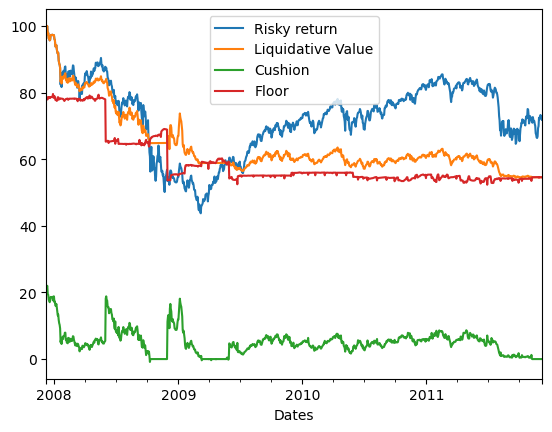

In [80]:
crucial2004.plot()

In [65]:
createxls(information2004,True)

The following excel is successfuly registered : DataFrame_2024_01_28_13_57_55
